In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

## Create test/train set from samples

In [2]:
samples_fp = os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv')
#samples = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
#samples.head(3)

In [3]:
train, test = mpe.test_train_aois_scenes(pd.read_csv(samples_fp))

In [4]:
X_train = np.array(np.array(train.loc[:,'r':'day_in_year']))
X_train

array([[43, 51, 78, ..., 2012, 5, 126],
       [65, 59, 84, ..., 2012, 5, 126],
       [81, 86, 93, ..., 2012, 5, 126],
       ...,
       [84, 100, 71, ..., 2020, 5, 142],
       [65, 77, 72, ..., 2020, 5, 142],
       [87, 93, 84, ..., 2020, 5, 142]], dtype=object)

In [5]:
# X_test = np.array(np.array(test.loc[:,'r':'day_in_year']))
# X_test

In [6]:
y_train = np.array(train['iceplant'])
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [7]:
# y_test = np.array(test['iceplant'])
# y_test

In [8]:
mpe.iceplant_proportions(y_train)

no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0         247696       70.95
1         101425       29.05



In [9]:
# mpe.iceplant_proportions(y_test)

## Train model

In [10]:
from dask_ml.wrappers import ParallelPostFit

In [11]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  31.200282096862793


In [12]:
# predictions = rfc.predict(X_test)
# mpe.print_threshold_metrics(y_test, predictions)


true negatives: 104377     false positives: 1925
false negatives: 2295     true positives: 41035

sensitivity (TP/P): 94.7 %
specificity (TN/N): 98.19 %
G-mean:  0.96

precision (TP/(TP+FP)): 95.52 %

MCC:  0.9312979351222674

F1-measure:  0.9511
F0.5-measure (min false positives):  0.95355
F2-measure (min false negatives)  :  0.94865

accuracy: 97.18 %



## Feature importance

In [22]:
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

In [23]:
# forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

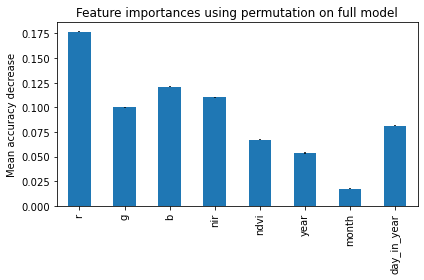

In [24]:
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

# Pre-process NAIP scene for prediction

In [12]:
itemid = 'ca_m_3412037_nw_10_060_20200607'

t0 = time.time()
item = ipf.get_item_from_id(itemid)
#scene = ipf.get_raster_from_item(item).read([1,2,3,4])
print('time to retrieve itemid: ', (time.time()-t0))

#scene.shape

time to retrieve raster:  0.37748241424560547


In [13]:
#df = ipf.spectral_df(ipf.get_raster_from_item(item).read([1,2,3,4]))
df = ipf.features_over_aoi(item, 
                           ipf.get_raster_from_item(item).read([1,2,3,4]), 
                           thresh=0.05)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
580,92,91,82,102,0.051546,2020,6,159
588,76,75,71,85,0.055901,2020,6,159
591,96,95,82,107,0.054187,2020,6,159


In [14]:
# df['year'] = item.datetime.year
# df['month'] = item.datetime.month
# df['day_in_year'] = day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)
# df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
0,73,92,95,14,-0.678161,2020,6,159
1,76,100,102,15,-0.670330,2020,6,159
2,79,98,100,16,-0.663158,2020,6,159


In [16]:
# df = df[['r','g','b','nir','ndvi','year','month','day_in_year']] # order features
# df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
0,73,92,95,14,-0.678161,2020,6,159
1,76,100,102,15,-0.670330,2020,6,159
2,79,98,100,16,-0.663158,2020,6,159


In [ ]:
# thresh = 0.05
# veg = df[df.ndvi>thresh]

In [17]:
# pixels = np.array(df)
# print(pixels.shape)
# pixels

(131184400, 8)


array([[  73.,   92.,   95., ..., 2020.,    6.,  159.],
       [  76.,  100.,  102., ..., 2020.,    6.,  159.],
       [  79.,   98.,  100., ..., 2020.,    6.,  159.],
       ...,
       [ 113.,  107.,  123., ..., 2020.,    6.,  159.],
       [  82.,   90.,  104., ..., 2020.,    6.,  159.],
       [ 100.,  112.,  117., ..., 2020.,    6.,  159.]])

This array is WAY TOO BIG. Mostly because the NDVI feature is a float and is making the whole array into a float. Maybe rescale the NDVI to make it uint16? Not sure if this would affect the model's predictions.

In [14]:
# Make dask data array of pixel values from NAIP scene raster
import dask.array as da

In [16]:
da_pixels = da.from_array(np.array(df), chunks=728802)
da_pixels

dask.array<array, shape=(23114446, 8), dtype=float64, chunksize=(728802, 8), chunktype=numpy.ndarray>

# Predict using dask

In [17]:
import dask
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.734c6ae241674334a56d9da2e74d4f86/status,


In [18]:
scene_preds = rfc.predict(da_pixels)
scene_preds

dask.array<_predict, shape=(23114446,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [19]:
t0 = time.time()
#print('starting time: ', t0)

preds = scene_preds.compute()
print((time.time()-t0))

65.15723180770874


In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    nrows = scene.shape[1]
    ncols = scene.shape[2]
    index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
    preds = ipf.indices_backto_image(nrows,ncols, index)
    print('converted back to image')

array([0, 0, 0, ..., 0, 0, 0])